# Hypothesis Testing in Healthcare

## Importing Data and Libraries

In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

drug_safety = pd.read_csv("drug_safety.csv")

print(drug_safety.head())

   age   sex   trx  week  wbc  rbc adverse_effects  num_effects
0   62  male  Drug     0  7.3  5.1              No            0
1   62  male  Drug     1  NaN  NaN              No            0
2   62  male  Drug    12  5.6  5.0              No            0
3   62  male  Drug    16  NaN  NaN              No            0
4   62  male  Drug     2  6.6  5.1              No            0


## Proportion Test
Testing to see whether the proportions of adverse effects for placebo and the test group are statistically different.Will be using a 5% Significant level
$$ H_{0}: \text{Proportion of adverse effects between drug and placebo group are the same}$$

$$H_{A}: \text{Proportion of adverse effects between drug and placebo group are different}
$$

### Visualising adverse effects based on Drug/Placebo group

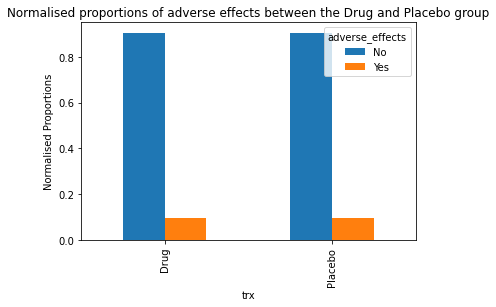

In [2]:
props = drug_safety.groupby('trx')['adverse_effects'].value_counts(normalize = True)
props_wide = props.unstack()
props_wide.plot(kind = 'bar')
plt.title('Normalised proportions of adverse effects between the Drug and Placebo group')
plt.ylabel('Normalised Proportions')
plt.savefig("Normalised proportions between groups.jpg", bbox_inches='tight')
plt.show()

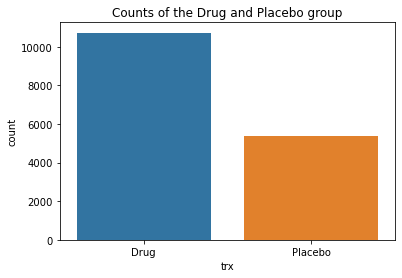

In [3]:
sns.countplot(data = drug_safety, x = 'trx')
plt.title('Counts of the Drug and Placebo group')
plt.savefig("Healthcare_adverse_effect_count.jpg", bbox_inches='tight')
plt.show()

In [4]:
values = drug_safety.groupby('trx')["adverse_effects"].value_counts()
print(values)

trx      adverse_effects
Drug     No                 9703
         Yes                1024
Placebo  No                 4864
         Yes                 512
Name: adverse_effects, dtype: int64


In [5]:
n_adverse_effects = [1024,512]
n_rows = [9703+1024,4864+512]

z_score, two_sample_p_value = proportions_ztest(count = n_adverse_effects, nobs = n_rows, alternative = 'two-sided')

print('The Z score is {} and has a p value of {}'.format(round(z_score,2), round(two_sample_p_value,2)))

The Z score is 0.05 and has a p value of 0.96


In [6]:
if two_sample_p_value < 0.025:
    print("Reject Null hypothesis and accept alternative hypothesis")
else:
    print("Fail to reject null hypothesis")

Fail to reject null hypothesis


As we can see from the p value we fail to reject the null hypothesis, as there isn't enough evidence to suggest that the proportion of adverse effects between the Drug and Placebo groups. This is also reflected visually in the first figure where the presence of adverse of effects between the two groups is almost indentically. This is despite the fact there are almost double the number of drug observations compared to placebo, as seen in the second figure. 

## Independence Test
Will be exploring whether the number of effects is independent of the treatment and control groups. Will be using a 5% significance level
$$H_0:\text{Number of effects are independent of which group the individual is placed} $$
$$H_A: \text{Number of effects are not independent of which group the individual is placed} $$
### Visualisation of Number Effects based on Drug and Placebo groups

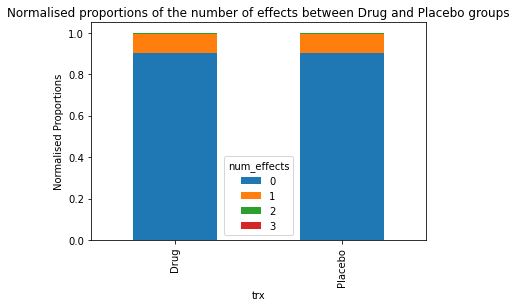

In [7]:
groups = drug_safety.groupby('trx')['num_effects'].value_counts(normalize = True)
wide_groups = groups.unstack()
wide_groups.plot(kind = 'bar', stacked = True)
plt.title('Normalised proportions of the number of effects between Drug and Placebo groups')
plt.ylabel('Normalised Proportions')
plt.savefig("norm prop num effects drug and placebo.jpg", bbox_inches='tight')
plt.show()

In [8]:
expected, observed, stats = pingouin.chi2_independence(data=drug_safety, x = 'trx',y='num_effects')
print(stats)
num_effects_p_value = stats[stats['test'] == 'pearson']['pval'][0]
print(round(num_effects_p_value,2))

                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  1.799644  3.0  0.615012  0.010572  0.176275
1        cressie-read  0.666667  1.836006  3.0  0.607131  0.010678  0.179153
2      log-likelihood  0.000000  1.922495  3.0  0.588648  0.010926  0.186033
3       freeman-tukey -0.500000  2.001752  3.0  0.572043  0.011149  0.192379
4  mod-log-likelihood -1.000000  2.096158  3.0  0.552690  0.011409  0.199984
5              neyman -2.000000  2.344303  3.0  0.504087  0.012066  0.220189
0.62


In [9]:
if num_effects_p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Fail to reject null hypothesis


Based on the results of the hypothesis test we accept the null hypothesis. There isn't enough evidence to suggest that there is association between the drug/placebo and the number of effects group. This is also reflected in the figure where the proportions between the groups are visually very similar. 

## Examining whether age impacted results of Drug and Placebo groups
Explore if there is a significant difference between the ages of the Drug and Placebo groups to see whether age played a role in the test. Will create a histogram of the data and will also perform a normality test to confirm the results. 

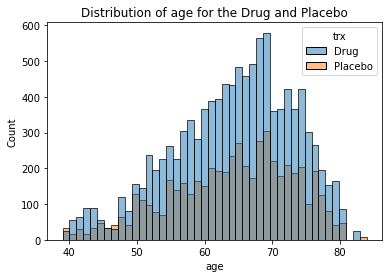

In [10]:
sns.histplot(data = drug_safety, x = 'age', hue = 'trx')
plt.title('Distribution of age for the Drug and Placebo')
plt.savefig("Distribution of age for the Drug and Placebo.jpg", bbox_inches='tight')
plt.show()

In [11]:
normal_test = pingouin.normality(data = drug_safety, dv = 'age', group = 'trx')
normal_test

,W,pval,normal
trx,,,
Drug,0.976797,2.228160e-38,False
Placebo,0.975590,2.209422e-29,False


As seen from distribution and normality test it is not a normal distribution. As we can't assume a normal distribution this eliminates pefroming an unpaired ttest. Instead to compare the means of the ages between the two groups the Wilcoxon-Mann-Whitney test will be performed, a 5% significance level will be used.
$$H_0: \text{The distribution of the two groups are the same}$$
$$H_A: \text{The distribution of the two groups are the different}$$

In [12]:
age_trx = drug_safety[["trx","age"]]
age_trx_wide = age_trx.pivot(columns = 'trx',values = 'age')
print(age_trx_wide.head())

trx  Drug  Placebo
0    62.0      NaN
1    62.0      NaN
2    62.0      NaN
3    62.0      NaN
4    62.0      NaN


In [13]:
results = pingouin.mwu(x = age_trx_wide['Drug'], y = age_trx_wide['Placebo'], alternative = 'two-sided')
age_group_effects_p_value = results['p-val']
print(age_group_effects_p_value)

MWU    0.256963
Name: p-val, dtype: float64


In [14]:
if age_group_effects_p_value[0] < 0.025:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Fail to reject null hypothesis


The results of the hypothesis test show that we must fail to reject the null hypothesis. The means there is not enough evidence to suggest that the distribution of ages between the two groups is different 